# ECON 5140: Applied Econometrics
## Lesson 1: Generalized Linear Models (GLM) - Tech Company Examples

This notebook demonstrates GLM methods using real-world examples from tech companies.

**Topics covered:**
1. Binary outcomes: Logistic and Probit regression (ad click prediction)
2. Count outcomes: Poisson regression (API usage/website visits)
3. Model comparison and interpretation


In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit, Probit
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families
from statsmodels.stats.stattools import durbin_watson

# Set style for better-looking plots
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Set random seed for reproducibility
np.random.seed(42)


## Part 1: Binary Outcomes - Ad Click Prediction

**Scenario:** A tech company wants to predict whether users will click on an advertisement based on:
- Time spent on website (minutes)
- Number of previous purchases
- User age
- Whether user is a premium member (0/1)

This is a classic binary classification problem where OLS fails because:
- Predictions can be outside [0,1]
- Errors are heteroskedastic
- We need to model probabilities, not outcomes directly


In [4]:
# Generate synthetic data for ad click prediction
n = 2000

# Generate covariates
time_on_site = np.random.exponential(5, n)  # Time in minutes
previous_purchases = np.random.poisson(2, n)  # Count of previous purchases
age = np.random.normal(35, 10, n).clip(18, 65)  # Age between 18-65
premium_member = np.random.binomial(1, 0.3, n)  # 30% are premium members

# True coefficients (latent variable model)
# [intercept, time_on_site, previous_purchases, age, premium_member]
beta_true = np.array([-2.0, 0.5, 0.3, -0.02, 1.2])
X = np.column_stack([
    np.ones(n),
    time_on_site,
    previous_purchases,
    age,
    premium_member
])

# Generate latent variable and binary outcome
# Using probit structure: Y* = X*beta + epsilon, Y = 1 if Y* > 0
epsilon = np.random.normal(0, 1, n)
y_star = X @ beta_true + epsilon
y_binary = (y_star > 0).astype(int)

# Create DataFrame
df_clicks = pd.DataFrame({
    'clicked': y_binary,
    'time_on_site': time_on_site,
    'previous_purchases': previous_purchases,
    'age': age,
    'premium_member': premium_member
})

print("Dataset Summary:")
print(df_clicks.describe())
print(f"\nClick rate: {df_clicks['clicked'].mean():.2%}")


Dataset Summary:
           clicked  time_on_site  previous_purchases          age  \
count  2000.000000   2000.000000         2000.000000  2000.000000   
mean      0.529000      5.019049            1.971000    35.099555   
std       0.499283      5.054749            1.353172     9.926705   
min       0.000000      0.016117            0.000000    18.000000   
25%       0.000000      1.359349            1.000000    27.755578   
50%       1.000000      3.539795            2.000000    34.707595   
75%       1.000000      6.945067            3.000000    42.072880   
max       1.000000     40.862228            8.000000    65.000000   

       premium_member  
count     2000.000000  
mean         0.310500  
std          0.462814  
min          0.000000  
25%          0.000000  
50%          0.000000  
75%          1.000000  
max          1.000000  

Click rate: 52.90%


### Why OLS Fails for Binary Outcomes


OLS Model Results:
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.2219      0.036      6.129      0.000       0.151       0.293
time_on_site           0.0580      0.002     33.814      0.000       0.055       0.061
previous_purchases     0.0538      0.006      8.387      0.000       0.041       0.066
age                   -0.0042      0.001     -4.776      0.000      -0.006      -0.002
premium_member         0.1825      0.019      9.735      0.000       0.146       0.219

Minimum predicted value: -0.0063
Maximum predicted value: 2.6236
Predictions outside [0,1]: 160 out of 2000


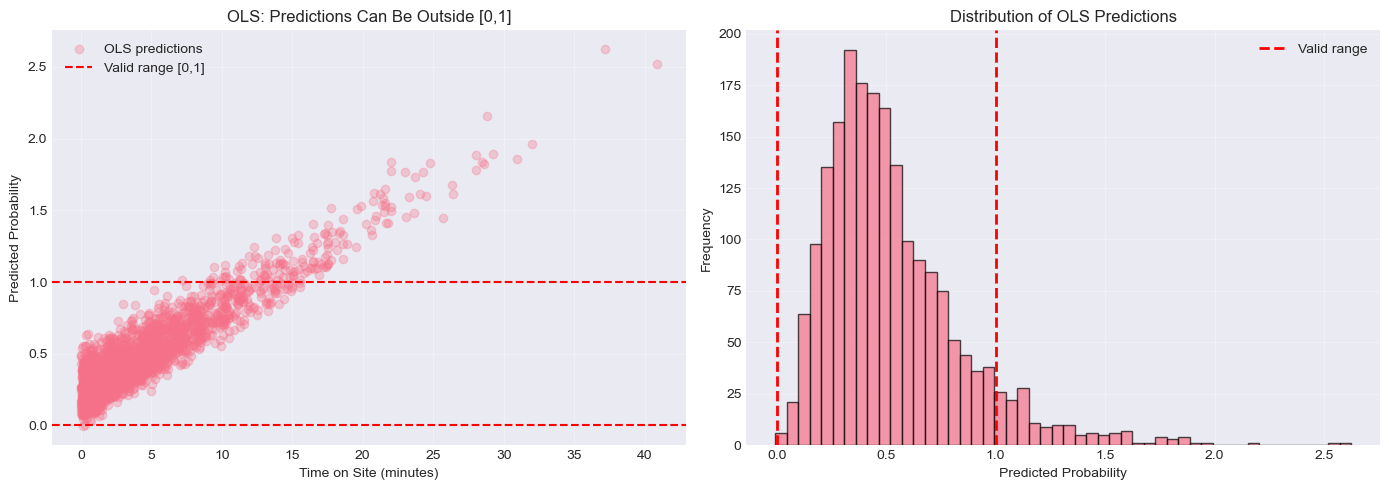

In [5]:
# Try OLS on binary outcome
X_ols = sm.add_constant(df_clicks[['time_on_site', 'previous_purchases', 'age', 'premium_member']])
ols_model = sm.OLS(df_clicks['clicked'], X_ols).fit()

# Predict probabilities
ols_pred = ols_model.predict(X_ols)

print("OLS Model Results:")
print(ols_model.summary().tables[1])
print(f"\nMinimum predicted value: {ols_pred.min():.4f}")
print(f"Maximum predicted value: {ols_pred.max():.4f}")
print(f"Predictions outside [0,1]: {((ols_pred < 0) | (ols_pred > 1)).sum()} out of {len(ols_pred)}")

# Visualize the problem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted probabilities vs actual
axes[0].scatter(df_clicks['time_on_site'], ols_pred, alpha=0.3, label='OLS predictions')
axes[0].axhline(y=0, color='r', linestyle='--', label='Valid range [0,1]')
axes[0].axhline(y=1, color='r', linestyle='--')
axes[0].set_xlabel('Time on Site (minutes)')
axes[0].set_ylabel('Predicted Probability')
axes[0].set_title('OLS: Predictions Can Be Outside [0,1]')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of predictions
axes[1].hist(ols_pred, bins=50, edgecolor='black', alpha=0.7)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Valid range')
axes[1].axvline(x=1, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of OLS Predictions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Logistic Regression (Logit Model)

The logit model uses the sigmoid function to map the linear predictor to valid probabilities:

$$P(Y=1|X) = \frac{1}{1 + e^{-X\beta}}$$

Or equivalently: $\log\left(\frac{p}{1-p}\right) = X\beta$


In [6]:
# Fit logistic regression
X_logit = sm.add_constant(df_clicks[['time_on_site', 'previous_purchases', 'age', 'premium_member']])
logit_model = Logit(df_clicks['clicked'], X_logit).fit()

print("Logistic Regression Results:")
print(logit_model.summary())


Optimization terminated successfully.
         Current function value: 0.322822
         Iterations 8
Logistic Regression Results:
                           Logit Regression Results                           
Dep. Variable:                clicked   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1995
Method:                           MLE   Df Model:                            4
Date:                Wed, 24 Dec 2025   Pseudo R-squ.:                  0.5331
Time:                        12:14:43   Log-Likelihood:                -645.64
converged:                       True   LL-Null:                       -1382.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -3.3642      0.315    -10.668      0.000 


Average Marginal Effects (Logit):
        Logit Marginal Effects       
Dep. Variable:                clicked
Method:                          dydx
At:                           overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
time_on_site           0.0923      0.001     65.827      0.000       0.090       0.095
previous_purchases     0.0516      0.005      9.868      0.000       0.041       0.062
age                   -0.0041      0.001     -5.657      0.000      -0.005      -0.003
premium_member         0.1810      0.014     12.578      0.000       0.153       0.209


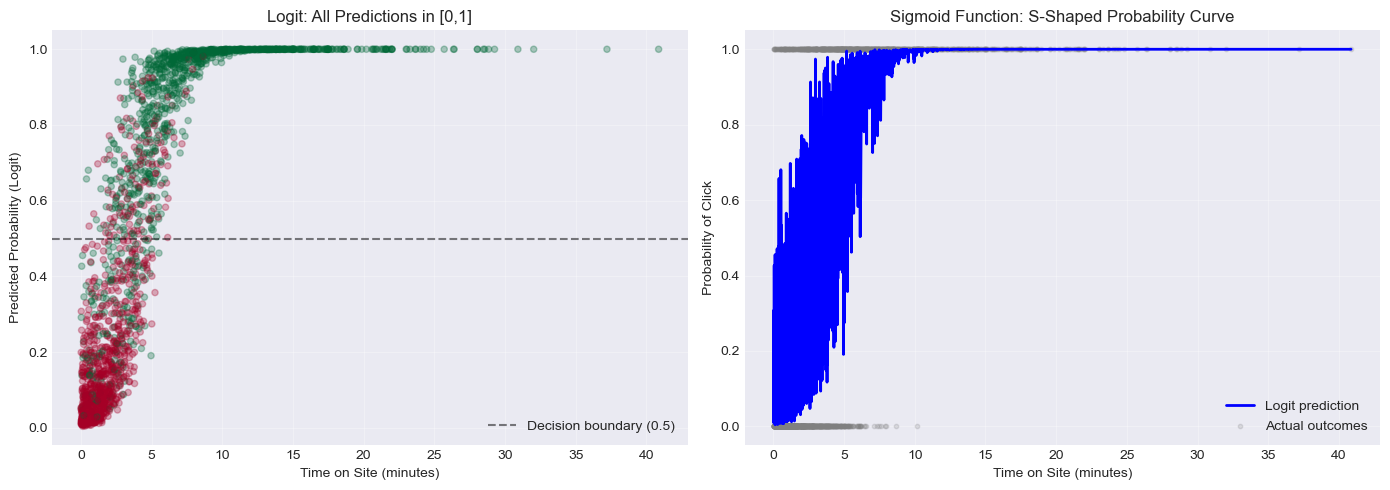


Logit predictions range: [0.0041, 1.0000]


In [7]:
# Get predicted probabilities from logit
logit_pred = logit_model.predict(X_logit)

# Calculate marginal effects (average marginal effects)
# For logit: ME = beta * p * (1-p)
marginal_effects = logit_model.get_margeff()
print("\nAverage Marginal Effects (Logit):")
print(marginal_effects.summary())

# Visualize logit predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predicted probabilities
axes[0].scatter(df_clicks['time_on_site'], logit_pred, alpha=0.3, c=df_clicks['clicked'], 
                cmap='RdYlGn', s=20)
axes[0].set_xlabel('Time on Site (minutes)')
axes[0].set_ylabel('Predicted Probability (Logit)')
axes[0].set_title('Logit: All Predictions in [0,1]')
axes[0].axhline(y=0.5, color='k', linestyle='--', alpha=0.5, label='Decision boundary (0.5)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: S-shaped curve
sorted_idx = np.argsort(df_clicks['time_on_site'])
axes[1].plot(df_clicks['time_on_site'].values[sorted_idx], 
             logit_pred.values[sorted_idx], 'b-', linewidth=2, label='Logit prediction')
axes[1].scatter(df_clicks['time_on_site'], df_clicks['clicked'], 
                alpha=0.2, s=10, color='gray', label='Actual outcomes')
axes[1].set_xlabel('Time on Site (minutes)')
axes[1].set_ylabel('Probability of Click')
axes[1].set_title('Sigmoid Function: S-Shaped Probability Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nLogit predictions range: [{logit_pred.min():.4f}, {logit_pred.max():.4f}]")


### Probit Regression

The probit model uses the standard normal CDF to map the linear predictor to probabilities:

$$P(Y=1|X) = \Phi(X\beta)$$

where $\Phi(\cdot)$ is the standard normal cumulative distribution function.

**Latent variable interpretation:** $Y^* = X\beta + \varepsilon$, where $\varepsilon \sim N(0,1)$, and $Y = 1$ if $Y^* > 0$.


In [8]:
# Fit probit regression
probit_model = Probit(df_clicks['clicked'], X_logit).fit()

print("Probit Regression Results:")
print(probit_model.summary())


Optimization terminated successfully.
         Current function value: 0.323487
         Iterations 8
Probit Regression Results:
                          Probit Regression Results                           
Dep. Variable:                clicked   No. Observations:                 2000
Model:                         Probit   Df Residuals:                     1995
Method:                           MLE   Df Model:                            4
Date:                Wed, 24 Dec 2025   Pseudo R-squ.:                  0.5322
Time:                        12:14:43   Log-Likelihood:                -646.97
converged:                       True   LL-Null:                       -1382.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 -1.8975      0.174    -10.887      0.000   


Average Marginal Effects (Probit):
       Probit Marginal Effects       
Dep. Variable:                clicked
Method:                          dydx
At:                           overall
                        dy/dx    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
time_on_site           0.0923      0.001     66.203      0.000       0.090       0.095
previous_purchases     0.0504      0.005      9.554      0.000       0.040       0.061
age                   -0.0041      0.001     -5.621      0.000      -0.005      -0.003
premium_member         0.1824      0.014     12.632      0.000       0.154       0.211


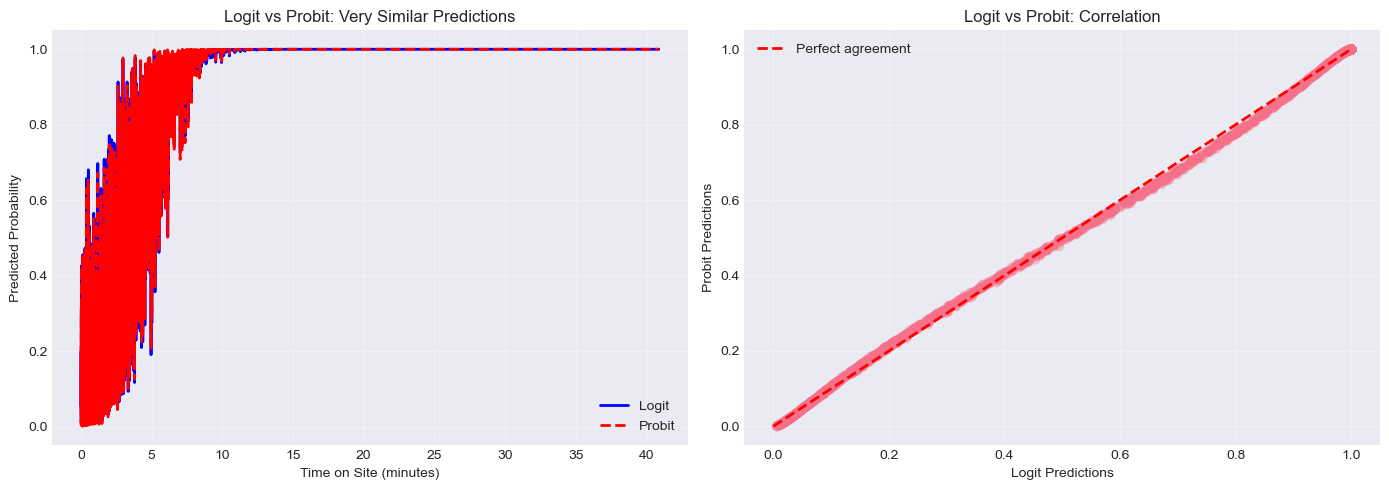


Correlation between logit and probit predictions: 0.9997


In [9]:
# Get predicted probabilities from probit
probit_pred = probit_model.predict(X_logit)

# Calculate marginal effects for probit
probit_marginal_effects = probit_model.get_margeff()
print("\nAverage Marginal Effects (Probit):")
print(probit_marginal_effects.summary())

# Compare logit and probit
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Compare predictions
sorted_idx = np.argsort(df_clicks['time_on_site'])
axes[0].plot(df_clicks['time_on_site'].values[sorted_idx], 
             logit_pred.values[sorted_idx], 'b-', linewidth=2, label='Logit')
axes[0].plot(df_clicks['time_on_site'].values[sorted_idx], 
             probit_pred.values[sorted_idx], 'r--', linewidth=2, label='Probit')
axes[0].set_xlabel('Time on Site (minutes)')
axes[0].set_ylabel('Predicted Probability')
axes[0].set_title('Logit vs Probit: Very Similar Predictions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Scatter of logit vs probit predictions
axes[1].scatter(logit_pred, probit_pred, alpha=0.3)
axes[1].plot([0, 1], [0, 1], 'r--', linewidth=2, label='Perfect agreement')
axes[1].set_xlabel('Logit Predictions')
axes[1].set_ylabel('Probit Predictions')
axes[1].set_title('Logit vs Probit: Correlation')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nCorrelation between logit and probit predictions: {np.corrcoef(logit_pred, probit_pred)[0,1]:.4f}")


### Model Comparison: Logit vs Probit

**Key takeaways:**
- Both models produce very similar predictions
- Coefficients differ in scale (probit coefficients are typically smaller)
- Marginal effects are usually very similar
- Choice rarely changes substantive conclusions


In [11]:
# Compare coefficients (note: probit coefficients are typically smaller)
# Exclude intercept from params to match marginal effects (which don't include intercept)
params_no_intercept = logit_model.params.drop('const')
probit_params_no_intercept = probit_model.params.drop('const')

comparison = pd.DataFrame({
    'Logit': params_no_intercept,
    'Probit': probit_params_no_intercept,
    'Logit_ME': marginal_effects.margeff,
    'Probit_ME': probit_marginal_effects.margeff
})
comparison['Ratio_Logit_Probit'] = comparison['Logit'] / comparison['Probit']

print("Coefficient Comparison (excluding intercept):")
print(comparison.round(4))

# Compare model fit
print("\nModel Fit Comparison:")
print(f"Logit Log-Likelihood: {logit_model.llf:.2f}")
print(f"Probit Log-Likelihood: {probit_model.llf:.2f}")
print(f"Logit AIC: {logit_model.aic:.2f}")
print(f"Probit AIC: {probit_model.aic:.2f}")


Coefficient Comparison (excluding intercept):
                     Logit  Probit  Logit_ME  Probit_ME  Ratio_Logit_Probit
time_on_site        0.9038  0.5090    0.0923     0.0923              1.7754
previous_purchases  0.5048  0.2780    0.0516     0.0504              1.8155
age                -0.0399 -0.0224   -0.0041    -0.0041              1.7779
premium_member      1.7720  1.0061    0.1810     0.1824              1.7612

Model Fit Comparison:
Logit Log-Likelihood: -645.64
Probit Log-Likelihood: -646.97
Logit AIC: 1301.29
Probit AIC: 1303.95


## Part 2: Count Outcomes - API Usage Prediction

**Scenario:** A cloud service provider wants to predict the number of API calls made by customers based on:
- Subscription tier (free, basic, premium)
- Number of active users
- Days since account creation
- Monthly subscription fee

This is a count outcome problem where:
- Outcomes are non-negative integers (0, 1, 2, ...)
- Variance increases with the mean
- OLS can produce negative predictions


In [17]:
# Generate synthetic data for Amazon transactions
n_count = 1500

# Generate covariates
prime_member = np.random.binomial(1, 0.4, n_count)  # 40% are Prime members
account_age_months = np.random.exponential(24, n_count).clip(1, 120)  # Months since registration
avg_order_value = np.random.lognormal(3.5, 0.8, n_count).clip(5, 500)  # Average order value in dollars
categories_browsed = np.random.poisson(3, n_count).clip(0, 15)  # Number of product categories

# True coefficients for Poisson (on log scale)
# Intercept set to give mean around 10, with right skew
# [intercept, prime_member, log(account_age), log(avg_order_value), categories_browsed]
beta_count_true = np.array([1.5, 0.6, 0.3, 0.4, 0.15])
X_count = np.column_stack([
    np.ones(n_count),
    prime_member,
    np.log(account_age_months + 1),  # Log transform for account age
    np.log(avg_order_value),  # Log transform for order value
    categories_browsed
])

# Generate count outcome using Poisson
# log(mu) = X*beta, so mu = exp(X*beta)
mu_true = np.exp(X_count @ beta_count_true)
y_count = np.random.poisson(mu_true)

# Create DataFrame
df_transactions = pd.DataFrame({
    'transactions': y_count,
    'prime_member': prime_member,
    'account_age_months': account_age_months,
    'avg_order_value': avg_order_value,
    'categories_browsed': categories_browsed
})

print("Amazon Transactions Dataset Summary:")
print(df_transactions.describe())
print(f"\nMean transactions: {df_transactions['transactions'].mean():.2f}")
print(f"Median transactions: {df_transactions['transactions'].median():.2f}")
print(f"Variance of transactions: {df_transactions['transactions'].var():.2f}")
print(f"Variance/Mean ratio: {df_transactions['transactions'].var() / df_transactions['transactions'].mean():.2f}")
print(f"Right skew: {df_transactions['transactions'].skew():.2f}")
print("(For Poisson, variance/mean should be close to 1)")


Amazon Transactions Dataset Summary:
       transactions  prime_member  account_age_months  avg_order_value  \
count   1500.000000   1500.000000         1500.000000      1500.000000   
mean      99.448667      0.395333           24.539164        47.075682   
std       63.886412      0.489085           24.248932        43.382676   
min       15.000000      0.000000            1.000000         5.000000   
25%       55.000000      0.000000            6.572862        19.812874   
50%       84.500000      0.000000           16.588062        34.416211   
75%      126.250000      1.000000           34.675733        58.363361   
max      602.000000      1.000000          120.000000       433.676714   

       categories_browsed  
count         1500.000000  
mean             2.980000  
std              1.721698  
min              0.000000  
25%              2.000000  
50%              3.000000  
75%              4.000000  
max             10.000000  

Mean transactions: 99.45
Median transaction

### Why OLS Fails for Count Data


OLS Model Results (Count Outcome):
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -34.0460      2.004    -16.987      0.000     -37.977     -30.115
prime_member          65.1261      1.532     42.508      0.000      62.121      68.131
account_age_months     1.1668      0.031     37.745      0.000       1.106       1.227
avg_order_value        0.6880      0.017     39.802      0.000       0.654       0.722
categories_browsed    15.6804      0.435     36.030      0.000      14.827      16.534

Minimum predicted value: -28.09
Maximum predicted value: 352.68
Negative predictions: 22 out of 1500
Percentage with negative predictions: 1.5%


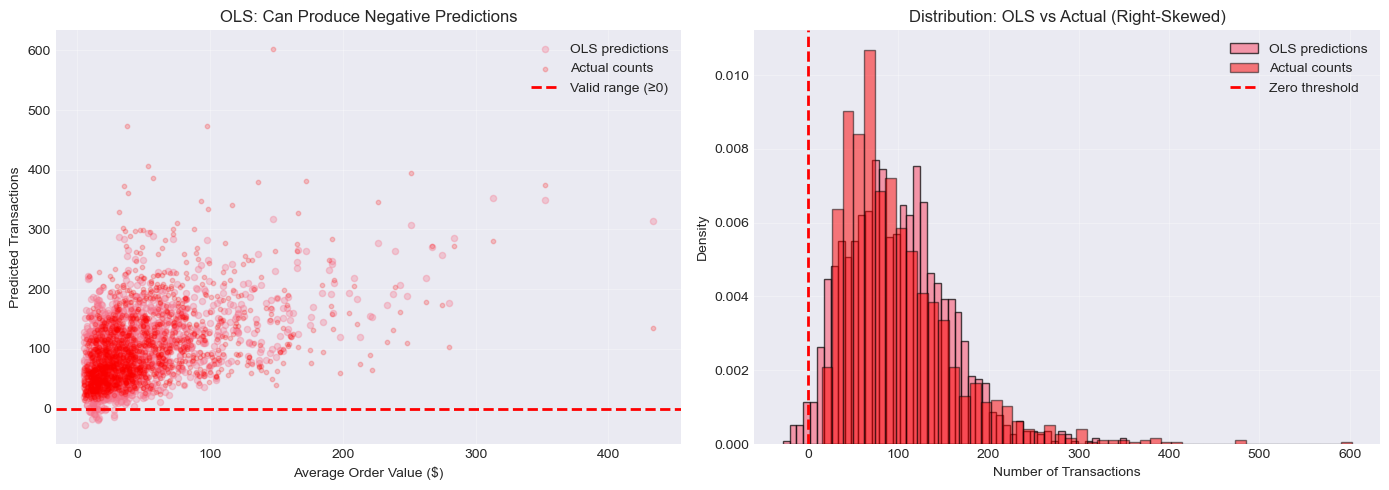

In [18]:
# Try OLS on count outcome
X_count_ols = sm.add_constant(df_transactions[['prime_member', 'account_age_months', 
                                                 'avg_order_value', 'categories_browsed']])
ols_count_model = sm.OLS(df_transactions['transactions'], X_count_ols).fit()

# Predict counts
ols_count_pred = ols_count_model.predict(X_count_ols)

print("OLS Model Results (Count Outcome):")
print(ols_count_model.summary().tables[1])
print(f"\nMinimum predicted value: {ols_count_pred.min():.2f}")
print(f"Maximum predicted value: {ols_count_pred.max():.2f}")
print(f"Negative predictions: {(ols_count_pred < 0).sum()} out of {len(ols_count_pred)}")
print(f"Percentage with negative predictions: {(ols_count_pred < 0).sum() / len(ols_count_pred) * 100:.1f}%")

# Visualize the problem
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions vs actual
axes[0].scatter(df_transactions['avg_order_value'], ols_count_pred, alpha=0.3, label='OLS predictions', s=20)
axes[0].scatter(df_transactions['avg_order_value'], df_transactions['transactions'], alpha=0.2, 
                color='red', s=10, label='Actual counts')
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2, label='Valid range (≥0)')
axes[0].set_xlabel('Average Order Value ($)')
axes[0].set_ylabel('Predicted Transactions')
axes[0].set_title('OLS: Can Produce Negative Predictions')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution of predictions
axes[1].hist(ols_count_pred, bins=50, edgecolor='black', alpha=0.7, label='OLS predictions', density=True)
axes[1].hist(df_transactions['transactions'], bins=50, edgecolor='black', alpha=0.5, 
             color='red', label='Actual counts', density=True)
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2, label='Zero threshold')
axes[1].set_xlabel('Number of Transactions')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution: OLS vs Actual (Right-Skewed)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### Poisson Regression

Poisson regression models count outcomes using:

- **Distribution:** $Y|X \sim \text{Poisson}(\mu)$
- **Link function:** $\log(\mu) = X\beta$ (canonical log link)
- **Properties:** $E[Y|X] = \mu$, $\text{Var}(Y|X) = \mu$

**Interpretation:** Coefficients are on the log-count scale. A one-unit increase in $X_k$ multiplies the expected count by $e^{\beta_k}$.


In [19]:
# Prepare data for Poisson regression
X_poisson = sm.add_constant(pd.DataFrame({
    'prime_member': df_transactions['prime_member'],
    'log_account_age': np.log(df_transactions['account_age_months'] + 1),
    'log_avg_order_value': np.log(df_transactions['avg_order_value']),
    'categories_browsed': df_transactions['categories_browsed']
}))

# Fit Poisson regression
poisson_model = GLM(df_transactions['transactions'], X_poisson, family=families.Poisson()).fit()

print("Poisson Regression Results:")
print(poisson_model.summary())


Poisson Regression Results:
                 Generalized Linear Model Regression Results                  
Dep. Variable:           transactions   No. Observations:                 1500
Model:                            GLM   Df Residuals:                     1495
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5461.4
Date:                Fri, 26 Dec 2025   Deviance:                       1528.6
Time:                        09:31:38   Pearson chi2:                 1.52e+03
No. Iterations:                     5   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const 


Coefficient Interpretation:
Intercept: 1.5023
Prime Member: 0.6063 (exp(0.6063) = 1.8336, +83.36% change per unit)
Log(Account Age): 0.2967 (exp(0.2967) = 1.3454, +34.54% change per unit)
Log(Avg Order Value): 0.4014 (exp(0.4014) = 1.4940, +49.40% change per unit)
Categories Browsed: 0.1497 (exp(0.1497) = 1.1614, +16.14% change per unit)


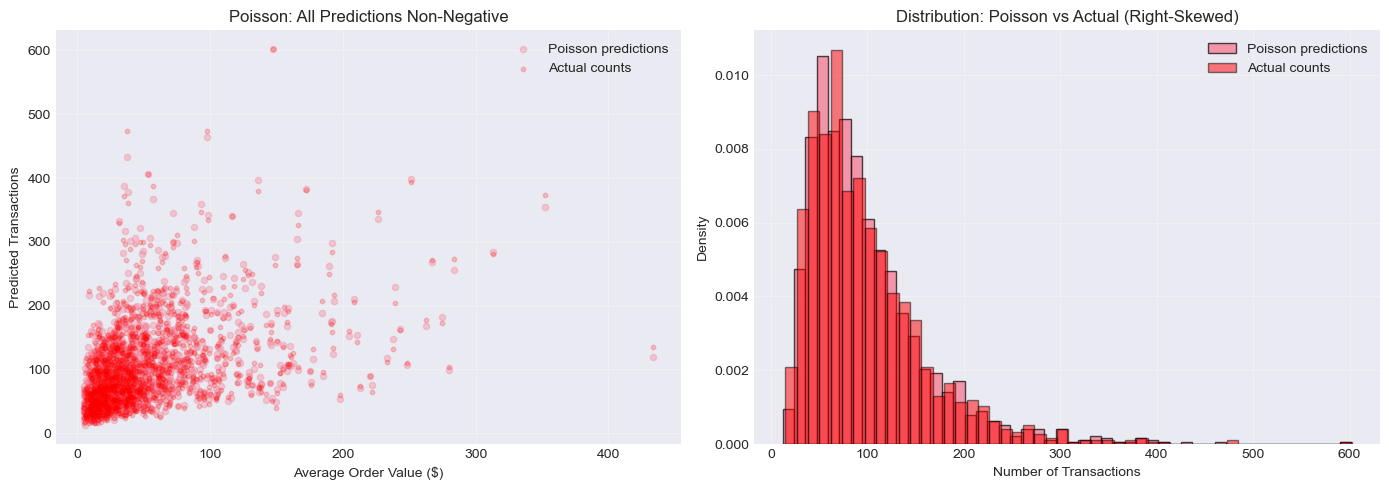


Poisson predictions range: [12.14, 601.58]
Negative predictions: 0


In [20]:
# Get predicted counts
poisson_pred = poisson_model.predict(X_poisson)

# Interpret coefficients
print("\nCoefficient Interpretation:")
print("=" * 60)
coef_names = ['Intercept', 'Prime Member', 'Log(Account Age)', 
              'Log(Avg Order Value)', 'Categories Browsed']
for i, (name, coef) in enumerate(zip(coef_names, poisson_model.params)):
    if i == 0:
        print(f"{name}: {coef:.4f}")
    else:
        pct_change = (np.exp(coef) - 1) * 100
        print(f"{name}: {coef:.4f} (exp({coef:.4f}) = {np.exp(coef):.4f}, "
              f"{pct_change:+.2f}% change per unit)")

# Visualize Poisson model
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions vs actual
axes[0].scatter(df_transactions['avg_order_value'], poisson_pred, alpha=0.3, 
                label='Poisson predictions', s=20)
axes[0].scatter(df_transactions['avg_order_value'], df_transactions['transactions'], alpha=0.2, 
                color='red', s=10, label='Actual counts')
axes[0].set_xlabel('Average Order Value ($)')
axes[0].set_ylabel('Predicted Transactions')
axes[0].set_title('Poisson: All Predictions Non-Negative')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Distribution comparison
axes[1].hist(poisson_pred, bins=50, edgecolor='black', alpha=0.7, 
             label='Poisson predictions', density=True)
axes[1].hist(df_transactions['transactions'], bins=50, edgecolor='black', alpha=0.5, 
             color='red', label='Actual counts', density=True)
axes[1].set_xlabel('Number of Transactions')
axes[1].set_ylabel('Density')
axes[1].set_title('Distribution: Poisson vs Actual (Right-Skewed)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nPoisson predictions range: [{poisson_pred.min():.2f}, {poisson_pred.max():.2f}]")
print(f"Negative predictions: {(poisson_pred < 0).sum()}")


### Model Comparison: OLS vs Poisson

**Key differences:**
- OLS can produce negative predictions (invalid for counts)
- Poisson ensures non-negative predictions
- Poisson accounts for mean-variance relationship
- Poisson coefficients have multiplicative interpretation


Model Comparison:
OLS - Negative predictions: 22
Poisson - Negative predictions: 0

OLS - Mean Absolute Error: 20.55
Poisson - Mean Absolute Error: 7.72

OLS - R-squared: 0.7945
Poisson - McFadden's Pseudo R-squared: 0.8233
  (Note: Cox-Snell pseudo R² = 1.0000 can be misleadingly high with synthetic data)


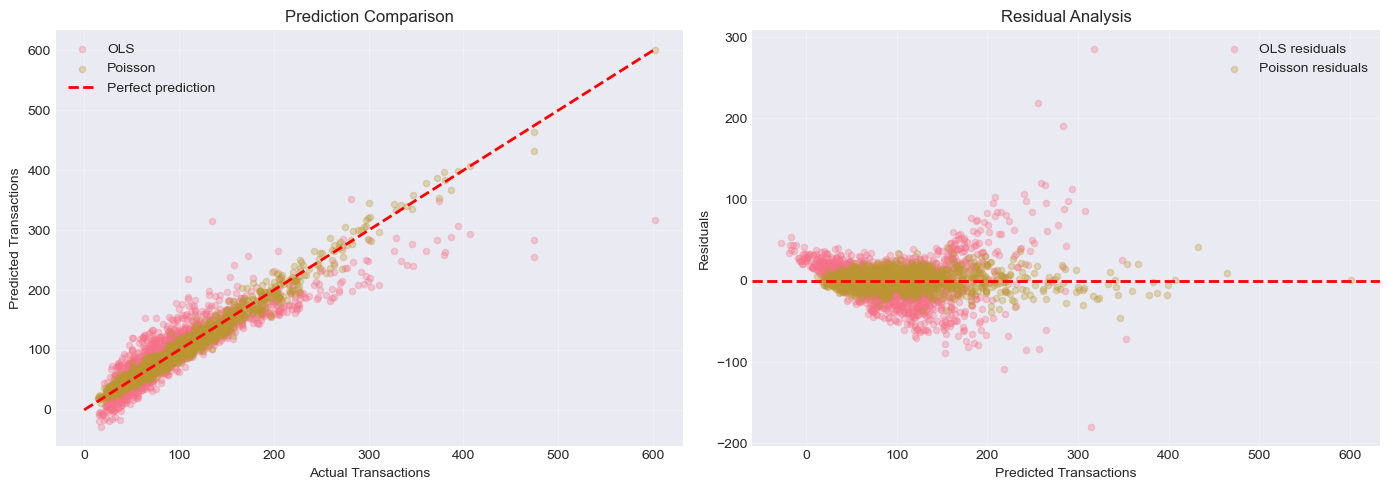

In [22]:
# Compare model performance
comparison_count = pd.DataFrame({
    'Actual': df_transactions['transactions'],
    'OLS': ols_count_pred,
    'Poisson': poisson_pred
})

# Calculate metrics
print("Model Comparison:")
print("=" * 60)
print(f"OLS - Negative predictions: {(ols_count_pred < 0).sum()}")
print(f"Poisson - Negative predictions: {(poisson_pred < 0).sum()}")
print(f"\nOLS - Mean Absolute Error: {np.mean(np.abs(df_transactions['transactions'] - ols_count_pred)):.2f}")
print(f"Poisson - Mean Absolute Error: {np.mean(np.abs(df_transactions['transactions'] - poisson_pred)):.2f}")
print(f"\nOLS - R-squared: {ols_count_model.rsquared:.4f}")

# Calculate McFadden's pseudo R-squared (more standard than Cox-Snell)
# McFadden's: 1 - (LL_model / LL_null)
# First fit a null model (intercept only)
null_model = GLM(df_transactions['transactions'], 
                 sm.add_constant(np.ones(len(df_transactions))), 
                 family=families.Poisson()).fit()
ll_model = poisson_model.llf
ll_null = null_model.llf
mcfadden_rsq = 1 - (ll_model / ll_null) if ll_null != 0 else 0
print(f"Poisson - McFadden's Pseudo R-squared: {mcfadden_rsq:.4f}")
print(f"  (Note: Cox-Snell pseudo R² = {poisson_model.pseudo_rsquared():.4f} can be misleadingly high with synthetic data)")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Predictions comparison
axes[0].scatter(df_transactions['transactions'], ols_count_pred, alpha=0.3, label='OLS', s=20)
axes[0].scatter(df_transactions['transactions'], poisson_pred, alpha=0.3, label='Poisson', s=20)
axes[0].plot([0, df_transactions['transactions'].max()], [0, df_transactions['transactions'].max()], 
             'r--', linewidth=2, label='Perfect prediction')
axes[0].set_xlabel('Actual Transactions')
axes[0].set_ylabel('Predicted Transactions')
axes[0].set_title('Prediction Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
ols_residuals = df_transactions['transactions'] - ols_count_pred
poisson_residuals = df_transactions['transactions'] - poisson_pred

axes[1].scatter(ols_count_pred, ols_residuals, alpha=0.3, label='OLS residuals', s=20)
axes[1].scatter(poisson_pred, poisson_residuals, alpha=0.3, label='Poisson residuals', s=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_xlabel('Predicted Transactions')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Analysis')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## Summary: GLM Framework

This notebook demonstrated the GLM framework with tech company examples:

### Key Takeaways:

1. **Binary Outcomes (Logit/Probit):**
   - OLS fails because predictions can be outside [0,1]
   - Logit and probit use nonlinear link functions to ensure valid probabilities
   - Both models produce very similar results
   - Coefficients need to be interpreted via marginal effects or odds ratios

2. **Count Outcomes (Poisson):**
   - OLS fails because predictions can be negative
   - Poisson regression uses log link to ensure non-negative predictions
   - Coefficients have multiplicative interpretation
   - Accounts for mean-variance relationship

3. **GLM Structure:**
   - All GLMs share: Linear predictor $\eta = X\beta$
   - They differ in: Distribution + Link function
   - Estimation via maximum likelihood

### When to Use Each Model:

| Outcome Type | Model | Example |
|-------------|-------|---------|
| Continuous | OLS | Revenue, prices |
| Binary | Logit/Probit | Click, purchase, default |
| Count | Poisson | API calls, visits, patents |
| Ordered categories | Ordered logit/probit | Rating scales, education levels |
| Unordered categories | Multinomial logit | Brand choice, transportation mode |

**Remember:** Choose the model based on the outcome distribution, not just convenience!


## References

- ECON 5140: Applied Econometrics, Lesson 1 - Generalized Linear Models
- Statsmodels documentation: https://www.statsmodels.org/
- Cameron, A. C., & Trivedi, P. K. (2013). *Regression Analysis of Count Data*
- Wooldridge, J. M. (2010). *Econometric Analysis of Cross Section and Panel Data*
